In [1]:
import pandas as pd
import json 


try:
    df = pd.read_csv('../data/INvideos.csv')
except UnicodeDecodeError:
    df = pd.read_csv('INvideos.csv', encoding='latin1')

print("CSV file loaded. Shape:", df.shape)
print("Columns in CSV:", df.columns)
print("\nFirst 5 rows of category_id column:")
print(df['category_id'].head())


# This code block reads the JSON, extracts the ID and name, and stores it in a dictionary.

category_map = {}
with open('../data/IN_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        # The ID from JSON is a string, the one in the CSV is an integer. We convert the JSON's ID to an integer.
        category_id = int(category['id'])
        category_name = category['snippet']['title']
        category_map[category_id] = category_name

print("\nSuccessfully created category mapping dictionary:")
print(category_map)


df['category_name'] = df['category_id'].map(category_map)



print("\nVerification: DataFrame with new 'category_name' column:")
print(df[['video_id', 'category_id', 'category_name']].head())


print("\nMost Popular Categories in India by number of trending videos:")
print(df['category_name'].value_counts())

CSV file loaded. Shape: (37352, 16)
Columns in CSV: Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description'],
      dtype='object')

First 5 rows of category_id column:
0     1
1    25
2    24
3    23
4    24
Name: category_id, dtype: int64

Successfully created category mapping dictionary:
{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-F

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Cleanning and Sorting the Data
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'])

# Sorting by video_id and then by date to ensure the time series is in the correct order
df = df.sort_values(by=['video_id', 'trending_date'])

print("Data sorted to build time series.")

# Creating a Time Series for Each Video
# Storing the normalized view history of each video in a dictionary.
video_timeseries = {}
for video_id, group in df.groupby('video_id'):
    # We need videos that trended for at least 4 days to analyze their shape
    if len(group) >= 4:
        # We focus on the 'views' column for the shape of virality
        views = group['views'].values.reshape(-1, 1) # Reshape for the scaler
        
        # Normalizing views for each video independently from 0 to 1
        scaler = MinMaxScaler()
        normalized_views = scaler.fit_transform(views)
        
        video_timeseries[video_id] = normalized_views.flatten() # Store as a flat array

print(f"Created time series for {len(video_timeseries)} videos.")

# Pad the Time Series to a Uniform Length
TARGET_LEN = 7
padded_timeseries = []
video_ids_for_clustering = []

for video_id, ts in video_timeseries.items():
    # If a series is longer than our target, we'll just take the first part
    if len(ts) >= TARGET_LEN:
        padded_timeseries.append(ts[:TARGET_LEN])
        video_ids_for_clustering.append(video_id)
    # If it's shorter, we'll "pad" it by repeating the last known value
    else:
        padding_needed = TARGET_LEN - len(ts)
        padding = np.full(padding_needed, ts[-1]) # Pad with the last value
        padded_series = np.concatenate([ts, padding])
        padded_timeseries.append(padded_series)
        video_ids_for_clustering.append(video_id)

# Preparation for tslearn
# Convert the list of arrays into a single NumPy array
X_train_clustering = np.array(padded_timeseries)


X_train_clustering = X_train_clustering.reshape(X_train_clustering.shape[0], TARGET_LEN, 1)

print("\nFinal shape of the data prepared for clustering:", X_train_clustering.shape)
print("This data is now ready for the TimeSeriesKMeans model.")

Data sorted to build time series.
Created time series for 2892 videos.

Final shape of the data prepared for clustering: (2892, 7, 1)
This data is now ready for the TimeSeriesKMeans model.


Starting the clustering process. This may take a moment...
Clustering complete.
Each of the 2892 videos has been assigned to one of 4 clusters.


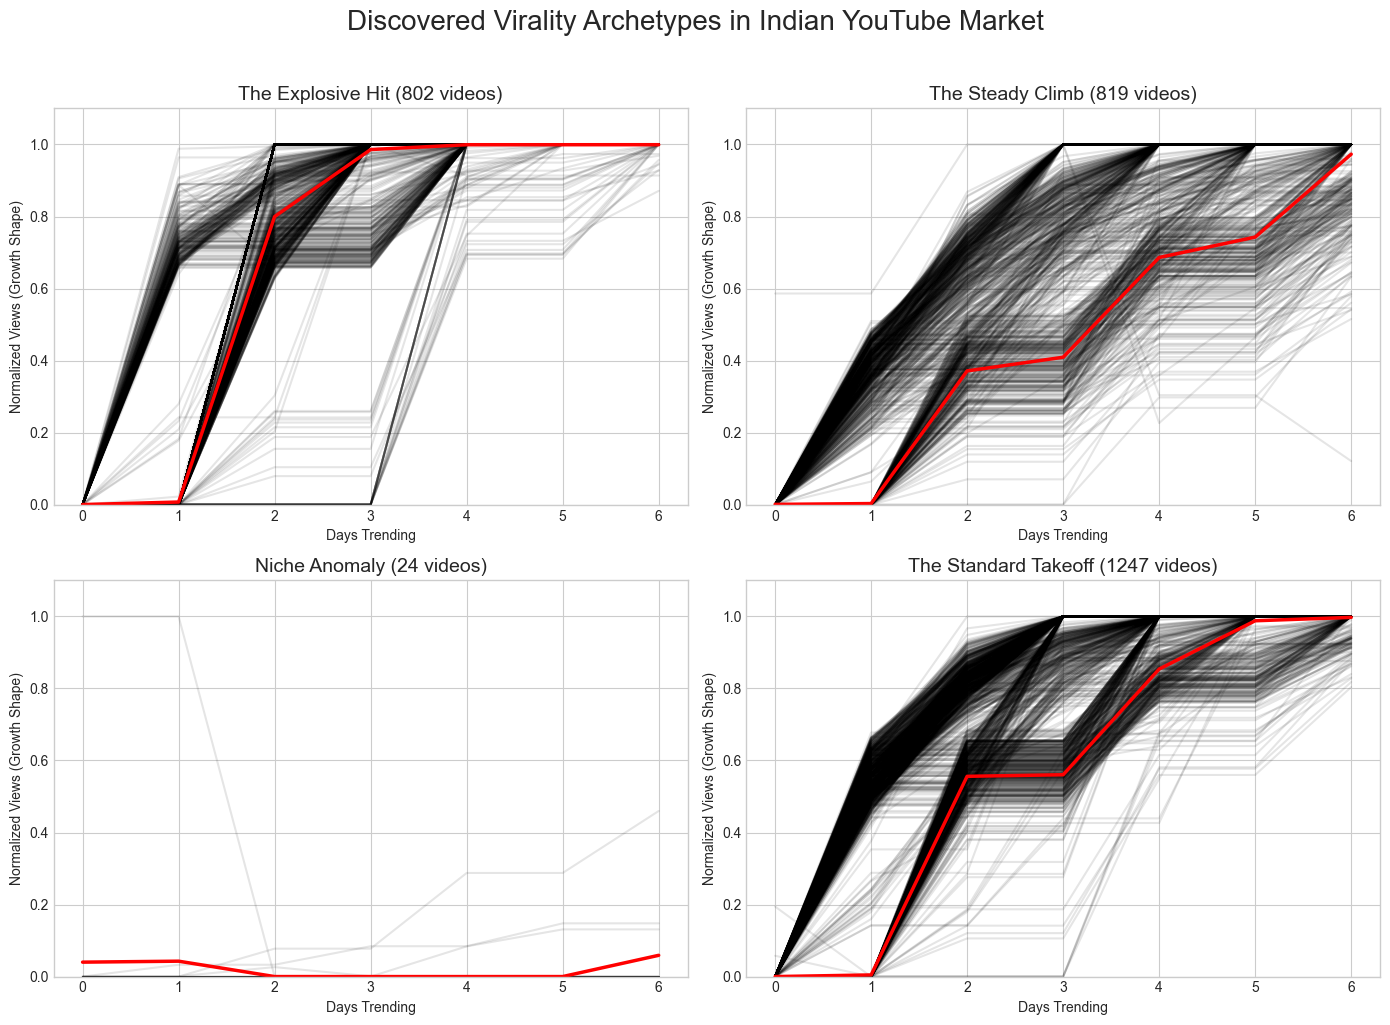


Plot has been successfully saved as virality_archetypes_plot.png in charts folder.


In [7]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

print("Starting the clustering process. This may take a moment...")

# Initializing and Training the Clustering Model
n_clusters = 4 
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=42, n_jobs=-1)

# Fit the model and get the cluster label for each of our 2892 videos.
y_pred_cluster = model.fit_predict(X_train_clustering)

print("Clustering complete.")
print(f"Each of the {len(y_pred_cluster)} videos has been assigned to one of {n_clusters} clusters.")

# Visualizing the Discovered Archetypes
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

archetype_names = {
    0: "The Explosive Hit",
    1: "The Steady Climb",
    2: "Niche Anomaly",
    3: "The Standard Takeoff"
}

for i in range(n_clusters):
    ax = axs[i]
    # Plot every time series belonging to this cluster in a light gray color
    for series in X_train_clustering[y_pred_cluster == i]:
        ax.plot(series.ravel(), "k-", alpha=.1)
    
    # Plot the "cluster center" - the representative shape of this archetype - in a bold color
    ax.plot(model.cluster_centers_[i].ravel(), "r-", linewidth=2.5)
    
    # Adding titles and labels for clarity
    # Using the meaningful names for the titles
    cluster_name = archetype_names.get(i, f"Archetype {i+1}")
    cluster_size = np.sum(y_pred_cluster == i)
    ax.set_title(f"{cluster_name} ({cluster_size} videos)", fontsize=14)   
    ax.set_xlabel("Days Trending")
    ax.set_ylabel("Normalized Views (Growth Shape)")
    ax.set_ylim(0, 1.1) # Set y-axis limits for consistent comparison

plt.suptitle("Discovered Virality Archetypes in Indian YouTube Market", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig("../charts/virality_archetypes_plot.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"\nPlot has been successfully saved as virality_archetypes_plot.png in charts folder.")

In [9]:
# Creating a DataFrame from the clustering results
df_clusters = pd.DataFrame({
    'video_id': video_ids_for_clustering, 
    'cluster': y_pred_cluster
})

# Data Cleaning Step
# Let's identify and count the invalid IDs before removing them.
invalid_ids = ['#NAME?', '#VALUE!']
initial_count = len(df_clusters)
print(f"Initial cluster results count: {initial_count}")
print(f"Number of rows with invalid ID '#NAME?': {len(df_clusters[df_clusters['video_id'] == '#NAME?'])}")
print(f"Number of rows with invalid ID '#VALUE!': {len(df_clusters[df_clusters['video_id'] == '#VALUE!'])}")

# Filter out the rows with invalid video_ids.
# keep only the rows where the video_id is NOT in the invalid_ids list.
df_clusters = df_clusters[~df_clusters['video_id'].isin(invalid_ids)]
cleaned_count = len(df_clusters)
print(f"Removed {initial_count - cleaned_count} rows with invalid IDs.")
print(f"Cleaned cluster results count: {cleaned_count}")

print("\nCleaned cluster results DataFrame:")
print(df_clusters.head())
print(f"Shape of cleaned cluster results: {df_clusters.shape}")


# Merging cluster labels back into the main DataFrame
df_main = pd.merge(df, df_clusters, on='video_id')

print("\nMain DataFrame after merging with cluster labels:")
print(df_main[['video_id', 'title', 'cluster']].head())
print(f"Shape of merged DataFrame: {df_main.shape}")


# Isolating the First Day of Data for Each Video
df_first_day = df_main.loc[df_main.groupby('video_id')['trending_date'].idxmin()]

print("\nDataFrame containing only the first day of data for each video:")
print(df_first_day[['video_id', 'trending_date', 'views', 'cluster']].head())
print(f"Shape of first-day DataFrame: {df_first_day.shape}")

Initial cluster results count: 2892
Number of rows with invalid ID '#NAME?': 1
Number of rows with invalid ID '#VALUE!': 1
Removed 2 rows with invalid IDs.
Cleaned cluster results count: 2890

Cleaned cluster results DataFrame:
      video_id  cluster
2  -0neBEVK-3Y        0
3  -0qyoTYp7Lg        0
4  -3FaXkFBUDo        3
5  -3iXPJwKItI        3
6  -4BScB2GHI8        0
Shape of cleaned cluster results: (2890, 2)

Main DataFrame after merging with cluster labels:
      video_id                                              title  cluster
0  -0neBEVK-3Y  Comedian Ali About Actor Gundu Hanumantha Rao'...        0
1  -0neBEVK-3Y  Comedian Ali About Actor Gundu Hanumantha Rao'...        0
2  -0neBEVK-3Y  Comedian Ali About Actor Gundu Hanumantha Rao'...        0
3  -0neBEVK-3Y  Comedian Ali About Actor Gundu Hanumantha Rao'...        0
4  -0neBEVK-3Y  Comedian Ali About Actor Gundu Hanumantha Rao'...        0
Shape of merged DataFrame: (15226, 18)

DataFrame containing only the first day of 

In [10]:
from langdetect import detect, LangDetectException

# Language and Title Features
def detect_language(title):
    try:
        lang = detect(title)
        if lang == 'en': return 'en'
        if lang == 'hi': return 'hi'
        return 'other'
    except LangDetectException:
        return 'unknown'

df_first_day['title_language'] = df_first_day['title'].apply(detect_language)
df_first_day['title_length'] = df_first_day['title'].apply(len)
df_first_day['has_question_mark'] = df_first_day['title'].str.contains(r'\?').astype(int)

#  Keyword Flagging for Indian Context
df_first_day['tags'] = df_first_day['tags'].astype(str) # Ensuring tags column is string type
df_first_day['has_cricket_keyword'] = df_first_day['tags'].str.contains('cricket|ipl|bcci', case=False).astype(int)
df_first_day['has_bollywood_keyword'] = df_first_day['tags'].str.contains('bollywood|movie|trailer|song|teaser', case=False).astype(int)
df_first_day['has_comedy_keyword'] = df_first_day['tags'].str.contains('comedy|funny|vines|sketch', case=False).astype(int)
df_first_day['has_news_keyword'] = df_first_day['tags'].str.contains('news|breaking|politics', case=False).astype(int)

# Channel Power Feature
# Identifying the top 20 most frequent channels as "power channels"
top_channels = df_first_day['channel_title'].value_counts().nlargest(20).index
df_first_day['is_from_top_channel'] = df_first_day['channel_title'].isin(top_channels).astype(int)

# Preparing for Modeling: One-Hot Encoding
# Converting categorical features (like category_name and title_language) into a numeric format
df_model_ready = pd.get_dummies(df_first_day, columns=['category_name', 'title_language'], prefix=['cat', 'lang'])

print("\nModel-ready DataFrame created with one-hot encoded features.")
print("Example columns:", [col for col in df_model_ready.columns if 'cat_' in col or 'lang_' in col][:5])


Model-ready DataFrame created with one-hot encoded features.
Example columns: ['cat_Autos & Vehicles', 'cat_Comedy', 'cat_Education', 'cat_Entertainment', 'cat_Film & Animation']



Data split into training (2167 samples) and testing (723 samples).

Training the XGBoost classifier...


D:\SOURABH\Projects 2\ML Projects\ML Project 2 Time-Series Forecasting of Viral Hits\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:28:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

Model Accuracy on Test Set: 0.4315

Classification Report:
                      precision    recall  f1-score   support

   The Explosive Hit       0.35      0.28      0.31       200
    The Steady Climb       0.49      0.35      0.41       205
       Niche Anomaly       0.00      0.00      0.00         6
The Standard Takeoff       0.44      0.59      0.51       312

            accuracy                           0.43       723
           macro avg       0.32      0.30      0.31       723
        weighted avg       0.43      0.43      0.42       723



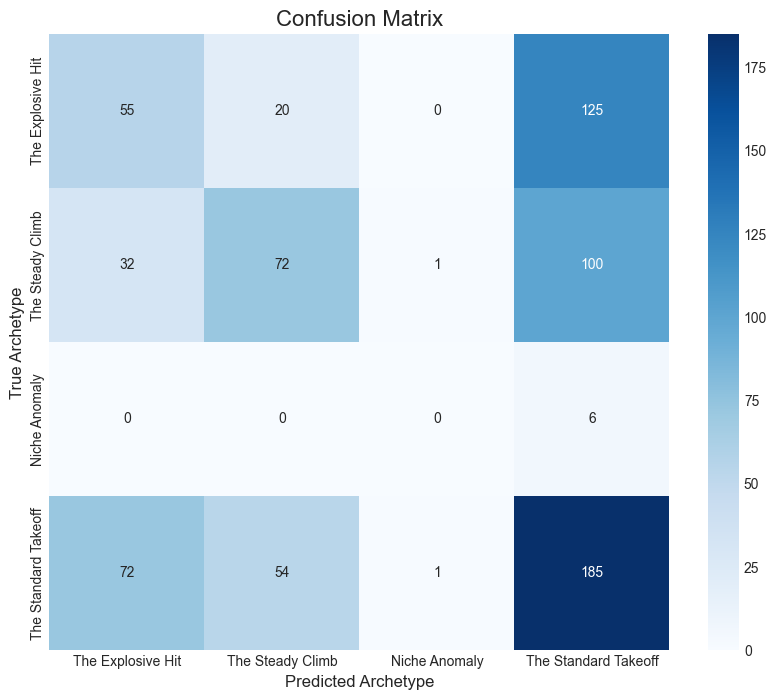

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Defining Features "X" and Target "y"
target = 'cluster'

# The features are all the numeric and engineered columns that can help predict the target.
features = [
    'views', 'likes', 'dislikes', 'comment_count', 
    'comments_disabled', 'ratings_disabled',
    'title_length', 'has_question_mark',
    'has_cricket_keyword', 'has_bollywood_keyword', 'has_comedy_keyword', 'has_news_keyword',
    'is_from_top_channel'
]
# Adding the one-hot encoded columns to our feature list
ohe_cols = [col for col in df_model_ready.columns if 'cat_' in col or 'lang_' in col]
features.extend(ohe_cols)

X = df_model_ready[features]
y = df_model_ready[target]

# Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nData split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples).")

# Training the XGBoost Model
classifier = xgb.XGBClassifier(
    objective='multi:softprob', 
    n_estimators=150,           
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

print("\nTraining the XGBoost classifier...")
classifier.fit(X_train, y_train)
print("Training complete.")

# Evaluating the Model's Performance
y_pred_classifier = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_classifier)
print(f"\nModel Accuracy on Test Set: {accuracy:.4f}")

# The classification report shows precision, recall, and f1-score for each archetype.
print("\nClassification Report:")
target_names = [archetype_names[i] for i in sorted(y_test.unique())]
print(classification_report(y_test, y_pred_classifier, target_names=target_names))

# Visualizing the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classifier)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Archetype', fontsize=12)
plt.ylabel('True Archetype', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.savefig("../charts/Confusion_Matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [25]:
import joblib

# Saving the trained classifier object to a file
joblib.dump(classifier, '../models/xgb_classifier.joblib')

print("Classifier saved successfully as 'xgb_classifier.joblib'")

Classifier saved successfully as 'xgb_classifier.joblib'


In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to create sequences for LSTM 
# This function will slide a window across the time series data.
def create_sequences(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# mapping the descriptive names back to the cluster numbers
cluster_name_map = {
    "The Explosive Hit": 0,      
    "The Steady Climb": 1,       
    "The Standard Takeoff": 3    
}

archetype_to_train = "The Explosive Hit"
cluster_id = cluster_name_map[archetype_to_train]

print(f"--- Preparing data for: {archetype_to_train} (Cluster {cluster_id}) ---")

# Filtering data for the specific archetype
df_archetype = df_main[df_main['cluster'] == cluster_id]

# process each video within this cluster
all_sequences_X = []
all_sequences_y = []

# Creating and scaling sequences for each video in the cluster
scaler = MinMaxScaler(feature_range=(0, 1))

# Group by video_id to process each time series individually
for video_id, group in df_archetype.groupby('video_id'):
    views = group['views'].values.reshape(-1, 1)
    
    # Fit the scaler Only on the training part of the data to avoid data leakage
    scaled_views = scaler.fit_transform(views)
    
    # Use function to create sequences from this video's data
    if len(scaled_views) > 3: 
        X_seq, y_seq = create_sequences(scaled_views, look_back=3)
        all_sequences_X.append(X_seq)
        all_sequences_y.append(y_seq)

# Concatenate all sequences from all videos in the cluster into one big dataset
X_train_lstm = np.concatenate(all_sequences_X)
y_train_lstm = np.concatenate(all_sequences_y)

print(f"Created {X_train_lstm.shape[0]} sequences for training.")
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of y_train_lstm:", y_train_lstm.shape)

--- Preparing data for: The Explosive Hit (Cluster 0) ---
Created 1192 sequences for training.
Shape of X_train_lstm: (1192, 3, 1)
Shape of y_train_lstm: (1192, 1)


In [20]:
# Build the LSTM Model Architecture
model_lstm = Sequential()
# The LSTM layer with 50 neurons. input_shape is (timesteps, features).
model_lstm.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
# The output layer is a single neuron to predict the single next view value.
model_lstm.add(Dense(1))
# Compile the model.
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

print("\nLSTM Model Summary:")
model_lstm.summary()

# Training the Model 
print(f"\nTraining LSTM model for '{archetype_to_train}'...")
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)
print("Training complete.")

# Saving the Trained Model and its Scaler
import pickle

# Saving the LSTM model to a H5 file
model_filename = f"lstm_model_cluster_{cluster_id}.h5"
model_lstm.save(model_filename)
print(f"Model saved as '{model_filename}'")

# saving the scaler used for this archetype's data.
scaler_filename = f"scaler_cluster_{cluster_id}.pkl"
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved as '{scaler_filename}'")


LSTM Model Summary:


D:\SOURABH\Projects 2\ML Projects\ML Project 2 Time-Series Forecasting of Viral Hits\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model for 'The Explosive Hit'...
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8131
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1517
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0407
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0272
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0241
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0231
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274


Training complete.
Model saved as 'lstm_model_cluster_0.h5'
Scaler saved as 'scaler_cluster_0.pkl'


In [21]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to create sequences for LSTM 
# This function will slide a window across the time series data.
def create_sequences(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# mapping the descriptive names back to the cluster numbers
cluster_name_map = {
    "The Explosive Hit": 0,      
    "The Steady Climb": 1,       
    "The Standard Takeoff": 3    
}

archetype_to_train = "The Steady Climb"
cluster_id = cluster_name_map[archetype_to_train]

print(f"--- Preparing data for: {archetype_to_train} (Cluster {cluster_id}) ---")

# Filtering data for the specific archetype
df_archetype = df_main[df_main['cluster'] == cluster_id]

# process each video within this cluster
all_sequences_X = []
all_sequences_y = []

# Creating and scaling sequences for each video in the cluster
scaler = MinMaxScaler(feature_range=(0, 1))

# Group by video_id to process each time series individually
for video_id, group in df_archetype.groupby('video_id'):
    views = group['views'].values.reshape(-1, 1)
    
    # Fit the scaler Only on the training part of the data to avoid data leakage
    scaled_views = scaler.fit_transform(views)
    
    # Use function to create sequences from this video's data
    if len(scaled_views) > 3: 
        X_seq, y_seq = create_sequences(scaled_views, look_back=3)
        all_sequences_X.append(X_seq)
        all_sequences_y.append(y_seq)

# Concatenate all sequences from all videos in the cluster into one big dataset
X_train_lstm = np.concatenate(all_sequences_X)
y_train_lstm = np.concatenate(all_sequences_y)

print(f"Created {X_train_lstm.shape[0]} sequences for training.")
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of y_train_lstm:", y_train_lstm.shape)

--- Preparing data for: The Steady Climb (Cluster 1) ---
Created 2675 sequences for training.
Shape of X_train_lstm: (2675, 3, 1)
Shape of y_train_lstm: (2675, 1)


In [22]:
# Build the LSTM Model Architecture
model_lstm = Sequential()
# The LSTM layer with 50 neurons. input_shape is (timesteps, features).
model_lstm.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
# The output layer is a single neuron to predict the single next view value.
model_lstm.add(Dense(1))
# Compile the model.
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

print("\nLSTM Model Summary:")
model_lstm.summary()

# Training the Model 
print(f"\nTraining LSTM model for '{archetype_to_train}'...")
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)
print("Training complete.")

# Saving the Trained Model and its Scaler
import pickle

# Saving the LSTM model to a H5 file
model_filename = f"lstm_model_cluster_{cluster_id}.h5"
model_lstm.save(model_filename)
print(f"Model saved as '{model_filename}'")

# saving the scaler used for this archetype's data.
scaler_filename = f"scaler_cluster_{cluster_id}.pkl"
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved as '{scaler_filename}'")


LSTM Model Summary:


D:\SOURABH\Projects 2\ML Projects\ML Project 2 Time-Series Forecasting of Viral Hits\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model for 'The Steady Climb'...
Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3087
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0230
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132


Training complete.
Model saved as 'lstm_model_cluster_1.h5'
Scaler saved as 'scaler_cluster_1.pkl'


In [23]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to create sequences for LSTM 
# This function will slide a window across the time series data.
def create_sequences(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# mapping the descriptive names back to the cluster numbers
cluster_name_map = {
    "The Explosive Hit": 0,      
    "The Steady Climb": 1,       
    "The Standard Takeoff": 3    
}

archetype_to_train = "The Standard Takeoff"
cluster_id = cluster_name_map[archetype_to_train]

print(f"--- Preparing data for: {archetype_to_train} (Cluster {cluster_id}) ---")

# Filtering data for the specific archetype
df_archetype = df_main[df_main['cluster'] == cluster_id]

# process each video within this cluster
all_sequences_X = []
all_sequences_y = []

# Creating and scaling sequences for each video in the cluster
scaler = MinMaxScaler(feature_range=(0, 1))

# Group by video_id to process each time series individually
for video_id, group in df_archetype.groupby('video_id'):
    views = group['views'].values.reshape(-1, 1)
    
    # Fit the scaler Only on the training part of the data to avoid data leakage
    scaled_views = scaler.fit_transform(views)
    
    # Use function to create sequences from this video's data
    if len(scaled_views) > 3: 
        X_seq, y_seq = create_sequences(scaled_views, look_back=3)
        all_sequences_X.append(X_seq)
        all_sequences_y.append(y_seq)

# Concatenate all sequences from all videos in the cluster into one big dataset
X_train_lstm = np.concatenate(all_sequences_X)
y_train_lstm = np.concatenate(all_sequences_y)

print(f"Created {X_train_lstm.shape[0]} sequences for training.")
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of y_train_lstm:", y_train_lstm.shape)

--- Preparing data for: The Standard Takeoff (Cluster 3) ---
Created 2645 sequences for training.
Shape of X_train_lstm: (2645, 3, 1)
Shape of y_train_lstm: (2645, 1)


In [24]:
# Build the LSTM Model Architecture
model_lstm = Sequential()
# The LSTM layer with 50 neurons. input_shape is (timesteps, features).
model_lstm.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
# The output layer is a single neuron to predict the single next view value.
model_lstm.add(Dense(1))
# Compile the model.
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

print("\nLSTM Model Summary:")
model_lstm.summary()

# Training the Model 
print(f"\nTraining LSTM model for '{archetype_to_train}'...")
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)
print("Training complete.")

# Saving the Trained Model and its Scaler
import pickle

# Saving the LSTM model to a H5 file
model_filename = f"lstm_model_cluster_{cluster_id}.h5"
model_lstm.save(model_filename)
print(f"Model saved as '{model_filename}'")

# saving the scaler used for this archetype's data.
scaler_filename = f"scaler_cluster_{cluster_id}.pkl"
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved as '{scaler_filename}'")


LSTM Model Summary:


D:\SOURABH\Projects 2\ML Projects\ML Project 2 Time-Series Forecasting of Viral Hits\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model for 'The Standard Takeoff'...
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4627
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0246
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133


Training complete.
Model saved as 'lstm_model_cluster_3.h5'
Scaler saved as 'scaler_cluster_3.pkl'
